# Demonstration of BNNs as uncertainty models

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sklearn.datasets
import sklearn.model_selection
import sklearn.preprocessing

import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow_datasets

import gandy.models.bnns

In [2]:
## loading the data
Xs, Ys = sklearn.datasets.load_boston(return_X_y=True)
Xsr, Xst, Ysr, Yst = sklearn.model_selection.train_test_split(Xs, Ys, train_size = 0.8)
Ysr = Ysr.reshape(-1,1); Yst = Yst.reshape(-1,1)
## normalizing the features and scaling the target
norm = sklearn.preprocessing.Normalizer()
scale = sklearn.preprocessing.StandardScaler()
Xsr = norm.fit_transform(Xsr)
Xst = norm.transform(Xst)
Ysr = scale.fit_transform(Ysr)
Yst = scale.transform(Yst)

In [3]:
print('X data: ', Xsr.shape, Xsr.dtype)
print('Y data: ', Ysr.shape, Ysr.dtype)

X data:  (404, 13) float64
Y data:  (404, 1) float64


Instantiate our model - using two hidden layers with 3 neurons each

In [4]:
# we have to specify ahead of time the training set size because of the kernel sizing
bnn = gandy.models.bnns.BNN(Xs.shape[1:], (1,), 
                            train_size=len(Xsr), 
                            metrics=['mae'],
                            neurons=(3,3))

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.


Train it for 1000 epochs, default batch size.

In [5]:
bnn.train(Xsr, Ysr, epochs=1000)

Epoch 1/1000
13/13 [==============================] - 1s 819us/step - loss: 8.5399 - mae: 1.1827
Epoch 2/1000
13/13 [==============================] - 0s 649us/step - loss: 12.8265 - mae: 1.2603
Epoch 3/1000
13/13 [==============================] - 0s 652us/step - loss: 9.4922 - mae: 1.2110
Epoch 4/1000
13/13 [==============================] - 0s 641us/step - loss: 8.1711 - mae: 1.1651
Epoch 5/1000
13/13 [==============================] - 0s 644us/step - loss: 7.6288 - mae: 1.1726
Epoch 6/1000
13/13 [==============================] - 0s 647us/step - loss: 9.7296 - mae: 1.2097
Epoch 7/1000
13/13 [==============================] - 0s 641us/step - loss: 6.5541 - mae: 1.1019
Epoch 8/1000
13/13 [==============================] - 0s 639us/step - loss: 5.6294 - mae: 1.0557
Epoch 9/1000
13/13 [==============================] - 0s 640us/step - loss: 8.6134 - mae: 1.1177
Epoch 10/1000
13/13 [==============================] - 0s 635us/step - loss: 4.9813 - mae: 1.0462
Epoch 11/1000
13/13 [=======

Make predictions, uncertainies are returned too.

In [6]:
preds, uncs = bnn.predict(Xst)

Unscale the target values and uncertainties

In [7]:
preds = scale.inverse_transform(preds)
Yst = scale.inverse_transform(Yst)
uncs *= np.sqrt(scale.var_)

Text(0.5, 1.0, 'True vs predicted with uncertainty')

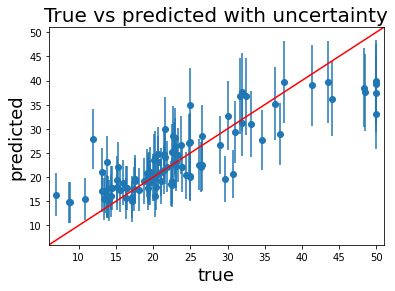

In [8]:
fig, ax = plt.subplots()
ax.scatter(Yst, preds)
minv, maxv = Yst.min()-1,  Yst.max()+1
ax.set_xlim(minv, maxv)
ax.set_ylim(minv, maxv)
ax.plot([minv, maxv], [minv, maxv], c='r')
ax.set_xlabel('true', size=18)
ax.set_ylabel('predicted', size=18)
ax.errorbar(Yst, preds, yerr=uncs.reshape(-1), ls='none')
ax.set_title('True vs predicted with uncertainty', size=20)

## Uncertainties are variable to the data, as we expect!

Uncertainties are larger in areas with fewer training dataum, eg. when the target is > 40 as we expect. Uncertainty is always on the range of including the true value, showing that our model is quite good at capturing what it "doesn't know"